In [10]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

from model import ShadowNet
from misc import loadModel, crf_refine

In [17]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision

from model import ShadowNet
from misc import loadModel, crf_refine, check_mkdir
import tqdm

from tools.evaluation import Evaluation

class Demo:
    def __init__(self, modelPath="./models/SBU_5000.pt"):
        self.net = ShadowNet().cuda()
        loadModel(self.net, modelPath)
        self.net.eval()

    def prepare(self, img):
        img = torchvision.transforms.ToTensor()(
            torchvision.transforms.Resize((416, 416))(
                img
            )
        )
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = torchvision.transforms.Normalize(mean, std)(img)
        return img.unsqueeze(0).cuda()

    def postProcess(self, img, pred):
        size = tuple(reversed(img.size))
        pred = torchvision.transforms.ToPILImage()(nn.Sigmoid()(pred["pred"][0][0]).cpu())
        pred = torchvision.transforms.Resize(size)(pred)
        pred_crf = crf_refine(
            np.array(img),
            np.array(pred)
        )
        return pred_crf

    def detect(self, img_path):
        img = Image.open(img_path)
        pred = self.net(self.prepare(img))
        pred_crf = self.postProcess(img, pred)
        return img, Image.fromarray(pred_crf)

    def eval(self, imgPath, outPath, gtPath, name="evaluation"):
        imgLst = [x for x in os.listdir(imgPath) if x.endswith(".jpg") or x.endswith(".png")]
        check_mkdir(outPath)
        for x in tqdm.tqdm(imgLst):
            img, pred = self.detect(os.path.join(imgPath, x))
            pred.save(os.path.join(outPath, x.replace(".jpg", ".png")))
        e = Evaluation(gtPath, outPath, name)
        e.calc()
        r = e.echo()
        print(r, flush=True)
        return r

## Evaluation over dataset

In [21]:
imgPath = "../dataset/SBU-shadow/SBU-Test/ShadowImages"
gtPath = "../dataset/SBU-shadow/SBU-Test/ShadowMasks"

demo = Demo(modelPath="models/SBU_5000u.pt")
demo.eval(imgPath=imgPath, outPath="SBU_test", gtPath=gtPath, name="sbu_test")

100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [04:46<00:00,  2.22it/s]



BER:3.053091
shadow Ber:2.888104
non-shadow BER:3.218078
accuracy:96.846294


BER:3.053091
shadow Ber:2.888104
non-shadow BER:3.218078
accuracy:96.846294



'\nBER:3.053091\nshadow Ber:2.888104\nnon-shadow BER:3.218078\naccuracy:96.846294\n'

## Evaluation on a single sample

adopt pretrained R101 weights


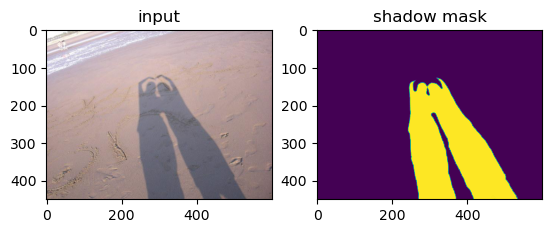

In [18]:
demo = Demo(modelPath="models/SBU_2000_trainontest.pt")
img, pred = demo.detect("./samples/1.jpg")

## visualize
plt.subplot(121)
plt.imshow(img)
plt.title("input")
plt.subplot(122)
plt.imshow(pred)
plt.title("shadow mask")
plt.show()

## Temp (Selection)

In [20]:
imgPath = "../dataset/SBU-shadow/SBUTrain4KRecoveredSmall/ShadowImages"
gtPath = "../dataset/SBU-shadow/SBUTrain4KRecoveredSmall/ShadowMasks"

# demo = Demo(modelPath="models/SBU_5000u.pt")
# print(demo.eval(imgPath=imgPath, outPath="SBU_train", gtPath=gtPath, name="sbu_train"))

In [21]:
def IOU(x, y):
    x = (x>127)*1.0
    y = (y>127)*1.0
    return (x * y).sum() / ((x+y-x*y).sum()+1e-6)

pred = r"SBU_2000_trainontest"
lst = [x for x in os.listdir(pred) if x.endswith(".png")]
scores = []
for x in tqdm.tqdm(lst):
    p = np.array(Image.open(os.path.join(pred, x)))
    gt = np.array(Image.open(os.path.join(gtPath, x)))
    scores.append([IOU(p, gt), x])
scores.sort()
scores = scores[::-1]
print(scores[0:3])

100%|█████████████████████████████████████████████████████████████████████████████| 4085/4085 [00:21<00:00, 189.09it/s]

[[0.9969129900014503, 'lssd1235.png'], [0.9951349906309125, 'lssd1041.png'], [0.9945304695056311, 'lssd3610.png']]


In [43]:
scores[2700]

[0.6062740893814449, 'lssd2533.png']

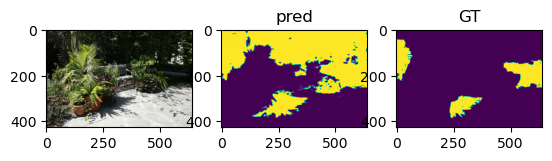

In [50]:
name = scores[-200][1][0:-4]
p = Image.open(os.path.join(pred, name+'.png'))
g = Image.open(os.path.join(gtPath, name+'.png'))
i = Image.open(os.path.join(imgPath, name+".jpg"))
## visualize
plt.subplot(131)
plt.imshow(i)
plt.subplot(132)
plt.imshow(p)
plt.title("pred")
plt.subplot(133)
plt.imshow(g)
plt.title("GT")
plt.show()

In [25]:
f = open("scores.txt", "w")
for s in scores:
    f.write("{name} {score}\n".format(name=s[1].replace(".png",".jpg"), score=round(s[0],3) ))
f.flush()
f.close()